In [1]:
%pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/Pratham")

In [4]:
import math
import random
import numpy as np
import json
import torch
from torch import nn
from collections import defaultdict
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses, models, evaluation
from sentence_transformers.evaluation import TripletEvaluator
from sklearn.metrics import f1_score

In [5]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Device: mps")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Device: cuda")
else:
    device = torch.device('cpu')
    print("Device: cpu")

Device: cuda


In [6]:
file_path_train = 'scicite/train.jsonl'
file_path_dev = 'scicite/dev.jsonl'
file_path_test = 'scicite/test.jsonl'
train_data = []
dev_data = []
test_data = []
with open(file_path_train, 'r', encoding='utf-8') as file:
    for line in file:
        train_data.append(json.loads(line))
with open(file_path_dev, 'r', encoding='utf-8') as file:
    for line in file:
        dev_data.append(json.loads(line))
with open(file_path_test, 'r', encoding='utf-8') as file:
    for line in file:
        test_data.append(json.loads(line))
print("Sample data points:")
print(train_data[0])
print(train_data[1])
print(train_data[2])
print("Keys:", list(train_data[0].keys()))
print("Number of training data points:", len(train_data))
print("Label distribution:", {x['label']: sum([1 for y in train_data if y['label'] == x['label']]) for x in train_data[:100]})

Sample data points:
{'source': 'explicit', 'citeEnd': 175, 'sectionName': 'Introduction', 'citeStart': 168, 'string': 'However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).', 'label': 'background', 'label_confidence': 1.0, 'citingPaperId': '1872080baa7d30ec8fb87be9a65358cd3a7fb649', 'citedPaperId': '894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'isKeyCitation': True, 'id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'unique_id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0_11', 'excerpt_index': 11}
{'source': 'explicit', 'citeStart': 16, 'sectionName': 'Novel Quantitative Trait Loci for Seminal Root Traits in Barley', 'string': 'In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological\nrobinson et al.

In [7]:
class CitationsDatasetWithoutInputExample():
    label_to_id = {'background': 0, 'method': 1, 'result': 2}
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]['string'], CitationsDatasetWithoutInputExample.label_to_id[self.data[item]['label']]

In [8]:
train_batch_size = 16
dev_batch_size = 16
test_batch_size = 16

In [9]:
train_dataset = CitationsDatasetWithoutInputExample(train_data)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

In [10]:
dev_dataset = CitationsDatasetWithoutInputExample(dev_data)
dev_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=dev_batch_size)

In [11]:
test_dataset = CitationsDatasetWithoutInputExample(test_data)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

In [12]:
class CitationIntentClassifier(nn.Module):
    def __init__(self, model_path, num_labels):
        super(CitationIntentClassifier, self).__init__()
        self.sentence_transformer = SentenceTransformer(model_path)
        self.classifier = nn.Linear(self.sentence_transformer.get_sentence_embedding_dimension(), num_labels)

    def forward(self, input_texts):
        embeddings = self.sentence_transformer.encode(input_texts, convert_to_tensor=True)
        return self.classifier(embeddings)

In [13]:
model_path = 'output/pre_trained_scibert-scicite'
num_labels = len(CitationsDatasetWithoutInputExample.label_to_id)
citation_intent_classifier = CitationIntentClassifier(model_path, num_labels).to(device)

In [14]:
model_state_dict = torch.load('output/citation_intent_classifier.pth')
citation_intent_classifier.load_state_dict(model_state_dict)

<All keys matched successfully>

In [15]:
def test(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            _, predicted_labels = torch.max(output, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

predictions, true_labels = test(citation_intent_classifier, test_dataloader, device)

In [16]:
f1 = f1_score(true_labels, predictions, average='macro')
print(f"F1 Score: {f1}")

F1 Score: 0.8779192931187527


In [17]:
# Plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_context("poster")
cm = confusion_matrix(true_labels, predictions)
cm

array([[911,  37,  49],
       [ 83, 506,  16],
       [ 20,   1, 238]])

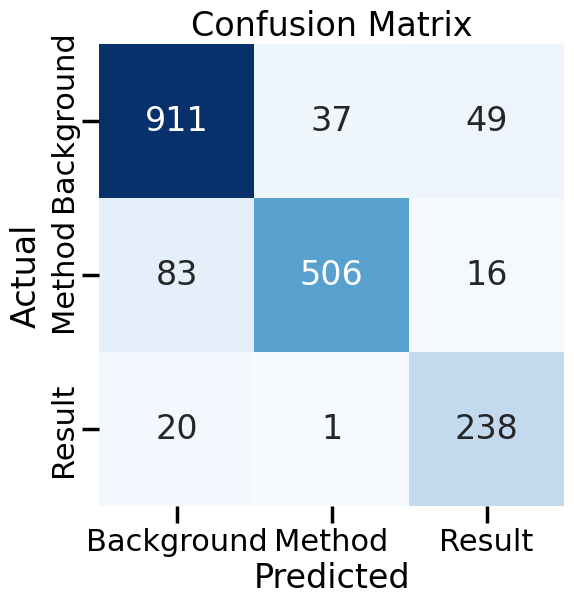

In [18]:
  plt.figure(figsize=(6, 6), dpi=100)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Background', 'Method', 'Result'], yticklabels=['Background', 'Method', 'Result'])
  plt.title(f'Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

## Divide data set into different subsets and get certain local metrics

In [19]:
len(test_data)

1861

In [20]:
unambiguous_data = list(map(lambda x: True if ('label_confidence' in x and x['label_confidence'] == 1) or ('label_confidence' not in x) else False, test_data))
len(unambiguous_data), unambiguous_data.count(1)

(1861, 1757)

In [21]:
ambiguous_data = list(map(lambda x: True if ('label_confidence' in x and x['label_confidence'] != 1) or ('label_confidence' not in x) else False, test_data))
len(ambiguous_data), ambiguous_data.count(1)

(1861, 1772)

In [22]:
unambiguous_true_labels, unambiguous_predictions = np.array(true_labels)[np.array(unambiguous_data) == True], np.array(predictions)[np.array(unambiguous_data) == True]

In [23]:
f1 = f1_score(unambiguous_true_labels, unambiguous_predictions, average='macro')
f1

0.8831472234273395

In [24]:
ambiguous_true_labels, ambiguous_predictions = np.array(true_labels)[np.array(ambiguous_data) == True], np.array(predictions)[np.array(ambiguous_data) == True]

In [25]:
f1 = f1_score(ambiguous_true_labels, ambiguous_predictions, average='macro')
f1

0.8774831514272506